### UserIntent.

In this notebook we are goin to create a model that does classification task for `UserIntent` using the dataset that we are going to use was found on [kaggle](https://www.kaggle.com/datasets/sahideseker/chatbot-intent-classification-dataset).

> https://www.kaggle.com/datasets/sahideseker/chatbot-intent-classification-dataset



### Installing Helper Packages

In the following code cell we are going to install the package called ``helperfns`` that provide us with some usefull helper functions for machine learning.

In [1]:
!pip install helperfns kaggle pigmenta -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 25.2 MB/s eta 0:00:00


### Imports

In the following code cell we are going to import all the packages that we are going to use throughout this notebook

In [2]:
import torch
import random
import warnings
import seaborn as sns
import os
import json
import re
import time

from collections import Counter, defaultdict
from helperfns.tables import tabulate_data
from pigmenta import PALETTES
from helperfns.visualization import plot_wordcloud, plot_classification_report, plot_complicated_confusion_matrix
from helperfns.utils import hms_string
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mutual_info_score, adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from torch import nn
from sklearn.utils import resample
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


torch:  2.6.0+cu124
numpy:  2.0.2
pandas:  2.2.2


### Setting seeds


In the following code cell we are going to set the seed to all random operations for reproducivity.

In [3]:
SEED = 23
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device
In the following code cell we are going to get ``gpu`` device if possible

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Data
We are going to download the data from `kaggle` at this url: https://www.kaggle.com/datasets/sahideseker/chatbot-intent-classification-dataset

In [5]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']

In [6]:
!kaggle datasets download sahideseker/chatbot-intent-classification-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/sahideseker/chatbot-intent-classification-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/2.29k [00:00<?, ?B/s]
100% 2.29k/2.29k [00:00<00:00, 8.01MB/s]


### Word Embeddings

In the following code cell we are going to download word embeddings from kaggle:

url: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation

In [7]:
!kaggle datasets download rtatman/glove-global-vectors-for-word-representation --unzip # glove vectors

Dataset URL: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation
License(s): other
 94% 429M/458M [00:04<00:00, 39.3MB/s]
100% 458M/458M [00:04<00:00, 102MB/s] 


Next we are going to read our data from text files into pandas dataframe using the `read_csv` method.

In [8]:
dataframe = pd.read_csv('chatbot_intent_classification.csv')
dataframe.head(2)

,user_input,intent
0,"Cancel my subscription, please.",cancellation
1,I forgot my password.,password_reset


In the next code cell we are then going to remove null values from the dataframe.

In [9]:
if sum(dataframe.isna().any()):
  dataframe.dropna(inplace=True)
  dataframe.reset_index(drop=True, inplace=True)
dataframe.isna().any()

,0
user_input,False
intent,False


Next we are going to check the distribution of labels in the dataset.

In [10]:
dataframe.intent.value_counts()

,count
intent,
business_hours,219
payment_update,117
account_help,103
order_status,102
technical_support,98
cancellation,96
service_info,91
password_reset,90
return_request,84


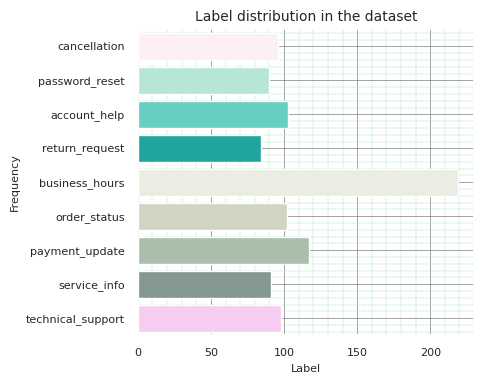

In [11]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(5, 4))
sns.countplot(data=dataframe, y="intent", palette=PALETTES.gradient,
              legend=False,  fill=True)
plt.xlabel("Label", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title(f"Label distribution in the dataset", fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

In the following code cell we are going to split the dataset into training and testing. The testing dataset is also the same dataset that we will use for model evaluation during training.

In [12]:
train, test = train_test_split(dataframe, test_size=0.2, random_state=SEED)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

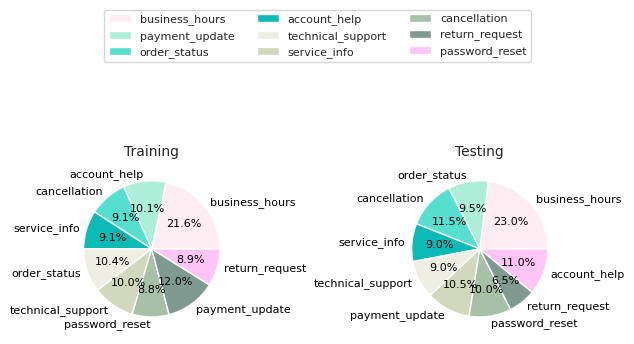

In [13]:
train_dist_label	= {i:0 for i in train.intent.unique()}
for val in train.intent:
  train_dist_label[val] += 1

test_dist_label	= {i:0 for i in test.intent.unique()}
for val in test.intent:
  test_dist_label[val] += 1

fig, axes = plt.subplots(1, 2)

axes[0].pie(train_dist_label.values(), labels=train_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=1,
            colors= PALETTES.gradient
            )
axes[0].set_title("Training", fontsize=10)

axes[1].pie(test_dist_label.values(), labels=test_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=1,
            colors= PALETTES.gradient
            )
axes[1].set_title("Testing", fontsize=10)

fig.legend(train.intent.value_counts().index, loc="upper center", bbox_to_anchor=(0.5, 1.01), ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

In [14]:
train_texts = train.user_input.values
train_labels = train.intent.values
test_texts = test.user_input.values
test_labels = test.intent.values

MENTION_HASHTAG_RE = re.compile(r"(@|#)([A-Za-z0-9]+)")
EMAIL_RE = re.compile(r"([A-Za-z0-9]+[._-])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Za-z]{2,})+")
URL_RE = re.compile(r"https?\S+", re.MULTILINE)
DIGIT_RE = re.compile(r"\d")
PUNCT_RE = re.compile(r"[^\w\s\']")
SPACE_RE = re.compile(r"\s+")

def clean_sentence(sent: str, lower: bool = True) -> str:
    if lower:
        sent = sent.lower()
    sent = MENTION_HASHTAG_RE.sub(" ", sent)
    sent = EMAIL_RE.sub(" ", sent)
    sent = URL_RE.sub(" ", sent)
    sent = DIGIT_RE.sub(" ", sent)
    sent = PUNCT_RE.sub(" ", sent)
    sent = SPACE_RE.sub(" ", sent).strip()
    return sent

In [15]:
train_text = [clean_sentence(i) for i in train_texts]
test_text = [clean_sentence(i) for i in test_texts]

In [16]:
from nltk.corpus import words
import nltk
nltk.download('words', quiet=True)
english_vocab = set(words.words())
def remove_non_english_words(text):
  tokens = text.split(" ")
  english_words = [word for word in tokens if word.lower() in english_vocab]
  return " ".join(english_words)

train_texts = [remove_non_english_words(i) for i in train_text]
test_texts = [remove_non_english_words(i) for i in test_text]

Next we are goint to create a counter object that will contain word counts that we are going to use to create our own vocabulary later on.

In [17]:
test_counter = Counter()
train_counter = Counter()
for line in train_texts:
    train_counter.update(line.lower().split())
for line in test_texts:
    test_counter.update(line.lower().split())

Next we are going to visualize the most common words in the dataset after it was cleaned using word clouds.

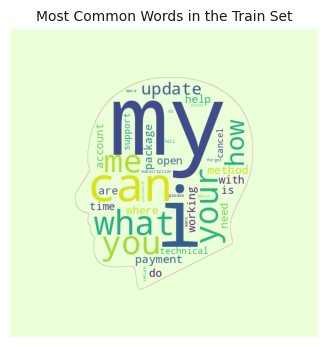

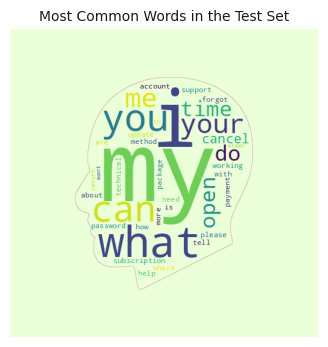

In [18]:
plot_wordcloud(
    train_counter, title="Most Common Words in the Train Set", mask="head", background_color=PALETTES.sky[0], figsize=(4, 4),
    fontsize=10
)
plot_wordcloud(
    test_counter, title="Most Common Words in the Test Set", mask="head", background_color=PALETTES.sky[0], figsize=(4, 4),
    fontsize=10
)

### Label pipeline
Our labels for now are just textual. We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a `labels_vocab` which is a label to integer representation.

In [19]:
labels_dict = {k: v for v, k in enumerate(train.intent.unique())}
labels_dict

{'business_hours': 0,
 'account_help': 1,
 'cancellation': 2,
 'service_info': 3,
 'order_status': 4,
 'technical_support': 5,
 'password_reset': 6,
 'payment_update': 7,
 'return_request': 8}

The `label_pipeline` function will then takes in the label and then returns us an integer representation of that label.



In [20]:
label_pipeline = lambda x: labels_dict[x]

### Vocabulary
Next we are going to create a vocabulary class and initialize it based on the `counter` object. We are going to specify the ``min_freq`` to ``2`` meaning that the words that does not appear at least ``2`` times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object.

In [21]:
class vocab:
    def __init__(self, counter, min_freq=1, specials=('[unk]', '[pad]', '[sos]', '[eos]')):
        self.freqs = counter
        self.itos = list(specials)
        self.stoi = {}
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.itos:
                self.itos.append(token)

        self.stoi = defaultdict(lambda: self.itos.index('[unk]'))  # default to unk
        for idx, token in enumerate(self.itos):
            self.stoi[token] = idx

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi[token]

    def get_stoi(self):
        return self.stoi
    def get_itos(self):
        return self.itos


vocabulary = vocab(train_counter, min_freq=2, specials=('[unk]', '[pad]', '[sos]', '[eos]'))

### STOI - ``String To Integer``
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called stoi which is essentially a dictionary of word to index mapping. This dictionary will be used during training as well as during model inference.

In [22]:
stoi = vocabulary.get_stoi()

### Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the ``text_pipeline`` function comes into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay (``stoi``) will be converted to an unkown (``'[unk]'``) token (0).

In [23]:
def text_pipeline(x: str):
  values = list()
  tokens = x.lower().split(" ") # convert to lower case.
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['[unk]']
    values.append(v)
  return values

### Pretrained vectors
In the following code cell we are going to download the predtrained word vectors. We are going to use the ``GloVe.6B.50d``. These are pretrained vectors that were trained with about ``~6B`` words and have a vector representation of a word in ``50`` dimension for each word.

In [24]:
embedding_path = "glove.6B.50d.txt"
EMBEDDING_DIM = 50
glove_vectors = dict()
with open(embedding_path, encoding="utf8") as glove:
  for line in glove:
    records = line.split();
    word = records[0]
    vectors = np.asarray(records[1: ], dtype=np.float32)
    glove_vectors[word] = vectors

### Creating Embedding matrix
Now that we have our glove vectors we need to costomize them so that they fit our use case. We are going to create an embedding matrix that suits the our vocabulary. So essentially this embedding matrix will be the word to vector mapping for all the words that arein our vocabulary.

In [25]:
VOCAB_SIZE = len(stoi)
EMBEDDING_MATRIX= torch.zeros([VOCAB_SIZE, EMBEDDING_DIM])
for word, index in stoi.items():
  vector = glove_vectors.get(word)
  if vector is not None:
    try:
      EMBEDDING_MATRIX[index] = torch.from_numpy(vector)
    except IndexError or Exception:
      pass


In [26]:
assert VOCAB_SIZE == EMBEDDING_MATRIX.size(0), "They should be the same"

In the followig code cell we are going to check the embedding matrix for the word ``"my"``.

In [27]:
EMBEDDING_MATRIX[stoi['my']]

tensor([-0.2728,  0.7752, -0.1018, -0.9166,  0.9048, -0.0705, -0.4757,  0.4461,
         0.1697,  0.0724, -0.1631,  0.8685, -0.7663, -0.0161,  0.7849,  0.2952,
        -0.7486,  0.2099,  0.6554, -0.6233, -0.4371,  1.1854,  0.4752,  0.0094,
         1.1377, -2.4394, -1.5619,  0.4900,  1.0985, -0.9737,  3.4628,  1.0408,
        -0.6514,  0.5719, -0.1252,  0.2670,  0.1637,  0.4110,  0.7509, -0.7792,
         0.0364, -0.2861, -0.7236,  0.6351,  0.0894, -0.3013,  0.3652, -0.7337,
         0.0404,  0.2666])

### Creating Dataset for Training
In the following code cell we are going to create a dataset class called `UserIntents`. This dataset will takes in the labels and the text of a set.

In [28]:
class UserIntents(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(UserIntents, self).__init__()
    self.text = text
    self.labels = labels

  def __getitem__(self, index):
    return self.labels[index], self.text[index]

  def __len__(self):
    return len(self.text)

### ``collate_fn``
We are going to create a collate function called ``tokenize_batch``. This function actually takes in a batch and does the preprocessing of the ``text`` . This function will be passed to the ``DataLoader`` class to do the preprocessing of ``features``.

### ``tokenize_batch`` function:

* this function takes in a batch in each set and convert the features to integer representation.
* It goes ahead and ``pad`` and ``truncate`` the sequence to the same length and returns ``features``.

In [29]:
def tokenize_batch(batch, max_len=50, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  features = torch.cat(text_list, dim=0)
  return torch.FloatTensor(labels_list) if len(set(labels_list)) == 2 else torch.LongTensor(labels_list), features

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `UserIntents` class.

In [30]:
train_dataset = UserIntents(train_labels, train_texts)
test_dataset = UserIntents(test_labels, test_texts)

### Iterators
In the following code cell we are going to create loaders using the ``DataLoader`` class from ``torch.utils.data``.

In [31]:
BATCH_SIZE = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

Checking a single Batch Data

In [32]:
lbl, txt = next(iter(train_loader))

Checking a single batch of labels.

In [33]:
lbl

tensor([3, 3, 4, 0, 2, 0, 7, 0])

The first sentence in the batch.

In [34]:
txt[0]

tensor([21, 14, 22, 23, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=torch.int32)

### UserIntentsBiLSTM

In the following code cell we are going to build a model using `LSTM` layers which we will use for classifying user intents.

In [35]:

class UserIntentsBiLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_size,
               hidden_size, output_size, num_layers,
               bidirectional, dropout, pad_index
               ):
    super(UserIntentsBiLSTM, self).__init__()
    self.embedding = nn.Sequential(
          nn.Embedding(
              vocab_size, embedding_size, padding_idx=pad_index
        )
    )

    self.lstm = nn.Sequential(
          nn.LSTM(
              embedding_size, hidden_size = hidden_size,
              bidirectional=bidirectional,
              num_layers=num_layers,
              dropout = dropout,
              batch_first=True,
          )
    )
    self.out = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=output_size)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, batch_first=True, enforce_sorted=False
    )
    packed_output, (hidden, cell) = self.lstm(packed_embedded)
    if self.lstm[0].bidirectional:
      hidden = torch.cat([hidden[-1], hidden[-2]], dim=-1)
    else:
      hidden = hidden[-1]
    return self.out(hidden)

Next we are going to create an instance of a `UserIntentsBiLSTM`.

In [36]:
INPUT_DIM = VOCAB_SIZE
EMBEDDING_DIM = 50
HIDDEN_DIM = 256
OUTPUT_DIM = 1 if len(labels_dict) == 2 else len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.6578
PAD_IDX = stoi['[pad]']
bilstm = UserIntentsBiLSTM(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)
bilstm

UserIntentsBiLSTM(
  (embedding): Sequential(
    (0): Embedding(41, 50, padding_idx=1)
  )
  (lstm): Sequential(
    (0): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.6578, bidirectional=True)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=9, bias=True)
  )
)

### Model Parameters

In the following code cell we are going to count parameters for our `UserIntentsBiLSTM` model.

In [37]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["BiLSTM", *count_trainable_params(bilstm)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+--------+--------------+------------------+
| MODEL  | TOTAL PARAMS | TRAINABLE PARAMS |
+--------+--------------+------------------+
| BiLSTM |    2,214,411 |        2,214,411 |
+--------+--------------+------------------+


### Loading Embedding Vectors
In the following code cells we are going to load the pretained custom vectors in our embedding layer to our model. We are going to load the embedding vectors tha suits our data using the ``model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)``

In [38]:
assert EMBEDDING_MATRIX.size(0) == VOCAB_SIZE, "This should match!"

In [39]:
bilstm.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.6805, -0.0393,  0.3019,  ..., -0.0733, -0.0647, -0.2604],
        [ 0.4428,  0.3140,  0.2097,  ...,  0.2150, -0.3798, -0.3064],
        [ 0.5959,  0.0274, -0.3721,  ..., -0.3774,  0.1814, -0.2711]])

### Optimizer and Criterion
We are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `CrossEntropyLoss()` function since this is a `multi-class` classification.

In [40]:
optimizer = torch.optim.Adam(bilstm.parameters())
criterion = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to create our `categorical_accuracy` function, which is a function that calulates the the catecorical accuracy between the predicted labels and real labels.

In [41]:
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

### Training and evaluation functions.
In the following code cell we are going to create our `train` and `evalute` functions:

In [42]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device).long()
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()
    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = categorical_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device).long()
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = categorical_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training Loop.
When training the model we are going to train our model. And we are also going to keep on tracking the training history of each model. The following `History` class is a data structure for our training history.

In [43]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

In the following code cell we are going to create the `run_train_loop` function.

In [44]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=6, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data = [
        ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
    ]
    columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [45]:
EPOCHS = 6
history, elt, last_saved_epoch = run_train_loop(
    bilstm, 'lstm.pt', train_loader, test_loader, EPOCHS,
    optimizer=optimizer, criterion=criterion
)


EPOCH: 01/06 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.626 |    0.800 | 0:00:37.40 |
| Validation | 0.003 |    1.000 |            |
+------------+-------+----------+------------+
EPOCH: 02/06 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.002 |    1.000 | 0:00:37.74 |
| Validation | 0.001 |    1.000 |            |
+------------+-------+----------+------------+
EPOCH: 03/06 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.001 |    1.000 | 0:00:40.01 |
| Validation | 0.001 |    1.000 |            |
+------------+-------+----------+------------+
EPOCH: 04/06 saving best model...
+------------+----

Next we are going to save the the files that we are going to use for model inference.

In [46]:
with open("vocab.json", 'w') as f:
  f.write(json.dumps(stoi, indent=2))

with open("labels_dict.json", 'w') as f:
  f.write(json.dumps(labels_dict, indent=2))
print("Done!")

Done!


Then we going to download the static file.

In [47]:
from google.colab import files
files.download('lstm.pt')
files.download('vocab.json')
files.download('labels_dict.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Next we are going to check the the last saved epoch and the total training time the `LSTM` model took.

In [48]:
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(elt)}']
]
tabulate_data(['', 'value'], rows, "LSTM MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH")

LSTM MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |          6 |
| LAST SAVED EPOCH    |          6 |
| TOTAL TRAINING TIME | 0:03:44.50 |
+---------------------+------------+


### Training History
In the following code cells we will be visualizing the training that we observed during training the model. The first plot that we will plot is about the training time that the model took to complete each epoch.

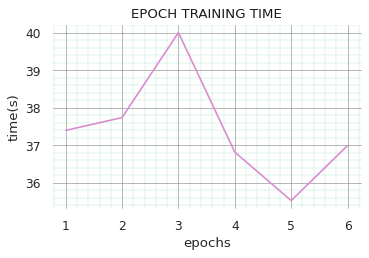

In [49]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, color=PALETTES.gradient[9], label='lstm')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation loss using a line graph for the model that was observed during model training.

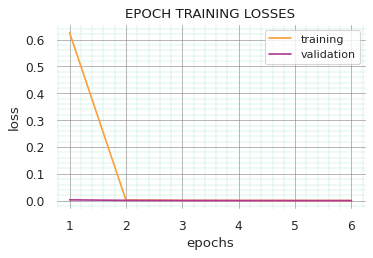

In [50]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color=PALETTES.gradient[14], label='training')
plt.plot(epochs, history.val_losses, color=PALETTES.gradient[11], label='validation')
plt.title("EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()


Next we are going to visualize the training and validation accuracies using a line graph for each model that was observed during model training.

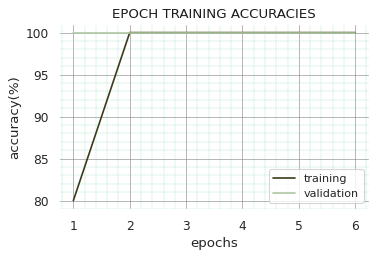

In [51]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in history.train_acc], color=PALETTES.gradient[20], label='training')
plt.plot(epochs, [acc * 100 for acc in history.val_acc], color=PALETTES.gradient[22], label='validation')

plt.title("EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Best model evaluations.
In the following code cell we are going to evaluate the best saved model for each model achitecture.

In [52]:
bilstm.load_state_dict(torch.load('lstm.pt'))
bilstm_test_loss, bistm_test_acc = evaluate(bilstm, test_loader, criterion)
print(f'Test Loss: {bilstm_test_loss:.3f} | Test Acc: {bistm_test_acc*100:.2f}%')

Test Loss: 0.000 | Test Acc: 100.00%


Next we are going to make predictions based with our test dataset for using our model.

In [53]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (y, X) in iterator:
      X = X.to(device)
      lengths = torch.tensor([len(i) for i in X])
      y_pred = model(X, lengths).squeeze(1)
      y_prob = F.softmax(y_pred).cpu().argmax(dim=1)
      labels.append(y.cpu())
      predictions.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0).numpy()
  predictions = torch.cat(predictions, dim = 0).numpy()
  return labels, predictions
y_true, y_preds = get_predictions(bilstm, test_loader, device)

### Confusion matrix
In the following code cell we are going to plot the Confusion Matrix of our model.

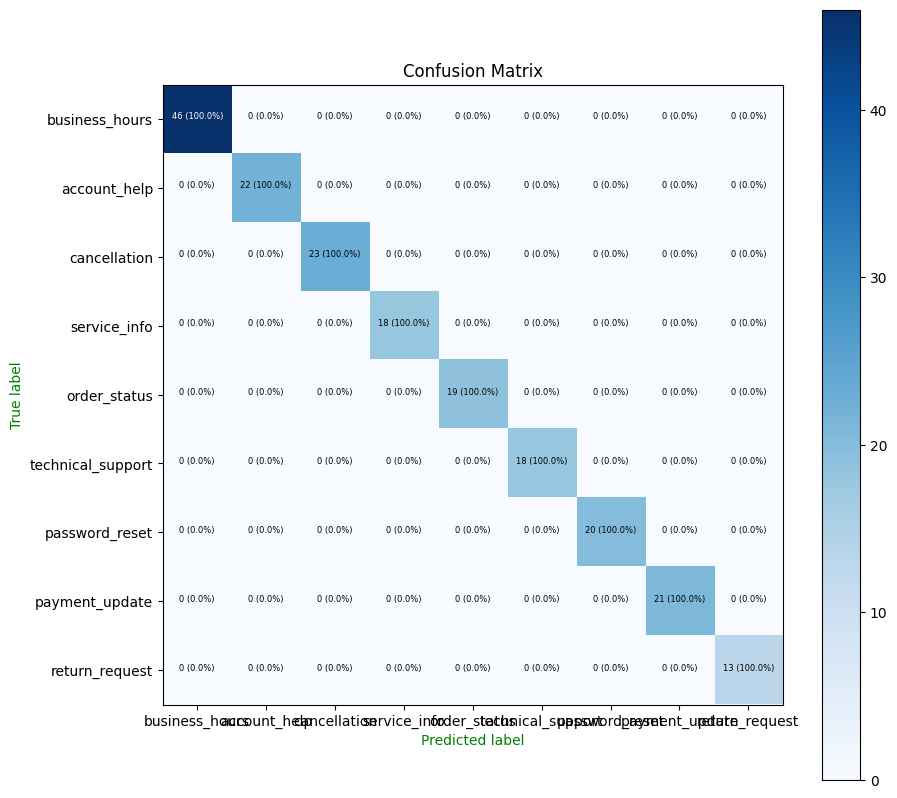

In [54]:
plt.style.use('default')
plot_complicated_confusion_matrix(y_true, y_preds,
  labels_dict.keys(), fontsize=6, figsize=(10, 10)
)

### Classification Report
Next we are going to plot the classification report of our model based on the test dataset.

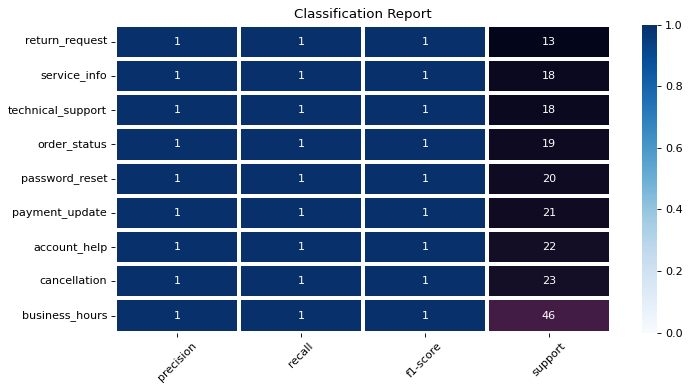

In [55]:
fig, ax = plot_classification_report(
    y_true, y_preds,
    title='Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = labels_dict.keys()
)

### Model Inference
In this section we are going to test our modelnif it can make predictions based on the user input.

In the following code cell we are going to make predictions with the best model. We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [56]:
def inference_preprocess_text(text, max_len=50, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with  = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

In [57]:
classes = list(labels_dict.keys())
def predict_intent(model, sentence, device):
    model.eval()
    with torch.no_grad():
      tensor = inference_preprocess_text(sentence).to(device)
      length = torch.tensor([len(t) for t in tensor])
      probs = F.softmax(model(tensor, length).squeeze(0))
      top = {
          'label': float(probs.argmax().item()),
          'probability': float(probs.max().item()),
          "class": classes[probs.argmax().item()]
      }
      predictions = [
          {
              'label': i,
              'probability': float(prob),
              "class": classes[i]
          } for i, prob in enumerate(probs)
      ]
      return {'top': top, 'predictions': predictions}

### Prediction Example

In the following code cell we are going to predict a simple order cancellation user intent.

In [58]:
predict_intent(bilstm, "Cancel my subscription, please.", device=device)

{'top': {'label': 2.0,
  'probability': 0.8154424428939819,
  'class': 'cancellation'},
 'predictions': [{'label': 0,
   'probability': 0.001247823121957481,
   'class': 'business_hours'},
  {'label': 1, 'probability': 5.5163694923976436e-05, 'class': 'account_help'},
  {'label': 2, 'probability': 0.8154424428939819, 'class': 'cancellation'},
  {'label': 3, 'probability': 2.1640891645802185e-05, 'class': 'service_info'},
  {'label': 4, 'probability': 0.15504364669322968, 'class': 'order_status'},
  {'label': 5,
   'probability': 0.02001149207353592,
   'class': 'technical_support'},
  {'label': 6,
   'probability': 0.00037291753687895834,
   'class': 'password_reset'},
  {'label': 7,
   'probability': 0.0008636179263703525,
   'class': 'payment_update'},
  {'label': 8,
   'probability': 0.006941258441656828,
   'class': 'return_request'}]}